In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


### Pre-processing Functions

Reshape input data

In [3]:
# Every "looK_back" X points, only one Y, does not predict future. 
def reshape_data(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2



def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


### Load Data

In [5]:
df=pd.read_csv('simple_well_portional_noise3_less.csv')

In [6]:
df.drop(columns='Date', inplace=True)
df2=pd.get_dummies(df['FlowPatternGasLiquid6'],prefix='FlowPattern')
df=pd.concat([df,df2],axis=1)
df.drop(columns='FlowPatternGasLiquid6', inplace=True)
df.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,2.006,434.3,4358.796496,5714.6,0.082530,0.802494,0.838955,397428.0850,0.514045,2.533015,0.012455,0.273919,2245.856283,212.007518,0,1
1,1.983,425.3,3954.486042,5569.2,0.084297,0.729662,0.820790,370815.2940,0.537978,2.317304,0.013136,0.275289,2167.784425,210.591058,0,1
2,1.971,423.3,3483.036837,5551.1,0.083442,0.658774,0.808913,335519.3383,0.525775,2.085509,0.012690,0.276644,2214.713037,208.827114,0,1
3,1.977,416.3,3290.559813,5483.7,0.085425,0.624417,0.796104,323486.3778,0.543198,1.981269,0.012918,0.277573,2191.448539,207.873805,0,1
4,1.961,410.4,2967.713050,5482.5,0.084584,0.575357,0.786456,298405.2945,0.530236,1.819061,0.012455,0.278797,2240.738376,206.288196,0,1


In [24]:
y_pre=df[['FINAPRESS','FINATEMP']]      # Pressure label
X_pre=df.iloc[:,0:11] # Pressure data

In [25]:
y_pre.head()

,FINAPRESS,FINATEMP
0,2245.856283,212.007518
1,2167.784425,210.591058
2,2214.713037,208.827114
3,2191.448539,207.873805
4,2240.738376,206.288196


### Pre-processing

In [26]:


# Split train-dev and test sets
test_fraction = 0.20
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_pre,
                                                  y_pre,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and val sets
dev_fraction = 0.20 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())  #based on train data
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = reshape_data(x_train_norm, y_train_norm, look_back=10)
x_dev, y_dev = reshape_data(x_dev_norm, y_dev_norm, look_back=10)
x_test, y_test = reshape_data(x_test_norm, y_test_norm, look_back=10)


# of data:  146
# of data:  42
# of data:  42
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. 

In [27]:
y_train.shape

(146, 2)

In [28]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=50, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](128, return_sequences=True)(inputs)    
    # equvilent to X=LSTM(512, return_sequences=True)(inputs)   
    X = classifier[method](128, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(64, activation='relu'))(X)
    # TimeDistrituted allows you to apply that Dense function across every output at same time
    # 2 outputs in current case
    # 2 results at the same time, hence 2 outputs, not 2 nodes. 
    X = Dropout(0.3)(X)
    
    out1 = Dense(1)(Flatten()(X)) # three well flow rates
    out2 = Dense(1)(Flatten()(X))
  
    
    model = Model(input=inputs, output=[out1, out2])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1]]), 
                        verbose=1, shuffle=False)
    return model, history

In [29]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=50, batch_size=80, method='LSTM')

 0.0068 - val_loss: 0.0162 - val_dense_8_loss: 0.0133 - val_dense_9_loss: 0.0029 - val_dense_8_mae: 0.1118 - val_dense_8_accuracy: 0.0000e+00 - val_dense_9_mae: 0.0523 - val_dense_9_accuracy: 0.0000e+00
Epoch 4/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0571 - dense_8_loss: 0.0439 - dense_9_loss: 0.0097 - dense_8_mae: 0.1508 - dense_8_accuracy: 0.0068 - dense_9_mae: 0.0734 - dense_9_accuracy: 0.0068 - val_loss: 0.0333 - val_dense_8_loss: 0.0300 - val_dense_9_loss: 0.0033 - val_dense_8_mae: 0.1691 - val_dense_8_accuracy: 0.0000e+00 - val_dense_9_mae: 0.0561 - val_dense_9_accuracy: 0.0000e+00
Epoch 5/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0621 - dense_8_loss: 0.0435 - dense_9_loss: 0.0143 - dense_8_mae: 0.1787 - dense_8_accuracy: 0.0137 - dense_9_mae: 0.0963 - dense_9_accuracy: 0.0068 - val_loss: 0.0219 - val_dense_8_loss: 0.0153 - val_dense_9_loss: 0.0065 - val_dense_8_mae: 0.1204 - val_dense_8_accuracy: 0.0000e+00 - val_dense_9_mae:

In [30]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

In [31]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

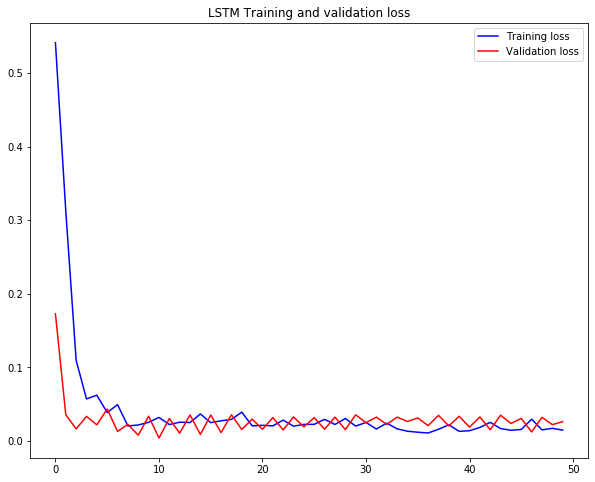

In [32]:
plot_train_history(history_LSTM,
                   'LSTM Training and validation loss')

In [33]:
from sklearn import metrics

def RNN_comp_plot(dnn, testy, pred, labelx, labely, ftitle):
    # Look at the results
    lw = 2
    
    fig= plt.figure(figsize=(12, 10))
   
    y_hat=pred
        
    MAE=format(metrics.mean_absolute_error(testy, y_hat),'.3f')
    MSE=format(metrics.mean_squared_error(testy, y_hat),'.2f')
    R2=format(metrics.r2_score(testy, y_hat),'.4f')        
        
    plt.plot(y_hat, color='blue', lw=lw,
                      label='{} (MAE: {},  R^2: {})'.format(dnn, MAE, R2))
    plt.plot(testy, color='red', linestyle=':', lw=3,
                      label='Test data')                    
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fontsize=12)
    plt.xlabel(labelx, fontsize=12)
    plt.ylabel(labely, fontsize=12)
    fig.suptitle(ftitle, fontsize=16)
    plt.show()

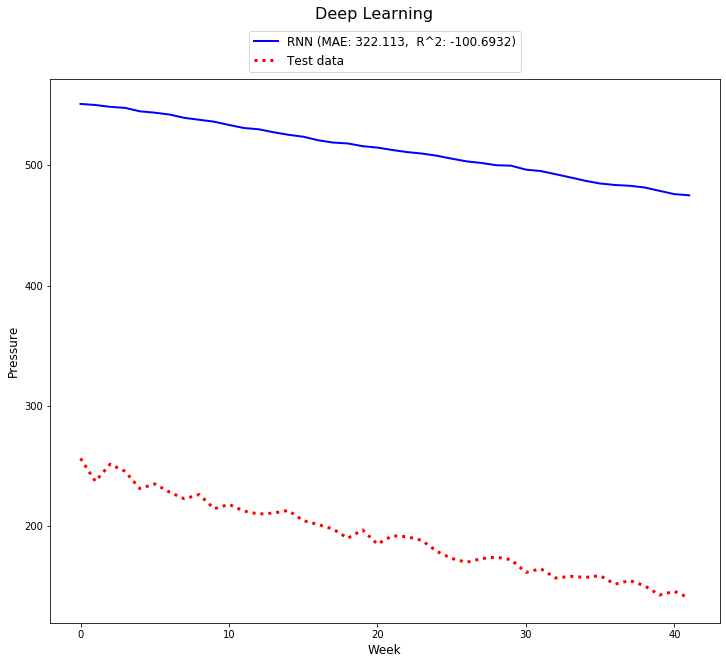

In [34]:
RNN_comp_plot("RNN",
              y_test_act[:,0],
              y_pred_test[:,0],
             "Week",
             "Pressure",
             "Deep Learning")